In [1]:
import csv  # for slang
import os
import re  # regex
import string  # punct
from pprint import pprint
!pip install emoji --upgrade
import emoji  # for emoji
import gensim
import keras
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from gensim.models import Word2Vec
from IPython.display import Image
from matplotlib import pyplot as plt
from nltk.corpus import stopwords  # stopwords
from nltk.stem import PorterStemmer  # stemming
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import svm, tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, RandomForestRegressor,
                              StackingClassifier)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, auc, average_precision_score,
                             brier_score_loss, classification_report,
                             confusion_matrix, f1_score, fbeta_score,
                             make_scorer, plot_precision_recall_curve,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC  # "Support vector classifier"
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from google.colab import files
uploaded = files.upload()
import nltk
nltk.download('stopwords')

%matplotlib inline

     |████████████████████████████████| 51kB 252kB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=1a32f0fc77863c5d9a984150b2e76b8e84813bfaf8632ada8988dffb8a7a6fea
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving slang.txt to slang.txt
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Clean Text Class

class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, input_text):
        '''
        Remove mentions, like @Mplamplampla
        '''
        return re.sub(r'@+', '', input_text)
    
    def remove_urls(self, input_text):
        '''
        Remove the urls mention in a tweet
        '''
        input_text  = ' '.join([w for w in input_text.split(' ') if '.com' not in w])
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        input_text = emoji.demojize(input_text)
        input_text = input_text.replace('_','')
        input_text = input_text.replace(':','')
        return input_text
    
    def possessive_pronouns(self, input_text):
        '''
        Remove the possesive pronouns, because otherwise after tokenization we will end up with a word and an s
        Example: government's --> ["government", "s"]
        '''
        return input_text.replace("'s", "")
    
    def characters(self, input_text):
        '''
        Remove special and redundant characters that may appear on a tweet and that don't really help in our analysis
        '''
        input_text = input_text.replace("\r", " ") # Carriage Return
        input_text = input_text.replace("\n", " ") # Newline
        input_text = " ".join(input_text.split()) # Double space
        input_text = input_text.replace('"', '') # Quotes
        return input_text
    
    def remove_punctuation(self, input_text):
        '''
        Remove punctuation and specifically these symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        '''
        punct = string.punctuation # string with all the punctuation symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        '''
        Remove numbers
        '''
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        '''
        Convert all the sentences(words) to lowercase
        '''
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        '''
        Remove stopwords (refers to the most common words in a language)
        '''
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        '''
        Reduce the words to their stem
        '''
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def encode_decode(self, input_text):
        '''
        Remove weird characters that are result of encoding problems
        '''
        return  " ".join([k.encode("ascii", "ignore").decode() for k in input_text.split(" ")])
    
    
    def translator(self, input_text):
        '''
        Transform abbrevations to normal words
        Example: asap --> as soon as possible
        '''
        input_text = input_text.split(" ")
        j = 0
        for _str in input_text:
            # File path which consists of Abbreviations.
            fileName = "/content/slang.txt"
            # File Access mode [Read Mode]
            accessMode = "r"
            with open(fileName, accessMode) as myCSVfile:
                # Reading file as CSV with delimiter as "=", so that 
                # abbreviation are stored in row[0] and phrases in row[1]
                dataFromFile = csv.reader(myCSVfile, delimiter="=")
                # Removing Special Characters.
                _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
                for row in dataFromFile:
                    # Check if selected word matches short forms[LHS] in text file.
                    if _str.upper() == row[0]:
                        # If match found replace it with its appropriate phrase in text file.
                        input_text[j] = row[1]
                myCSVfile.close()
            j = j + 1
        
        return(' '.join(input_text))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords)
                    .apply(self.stemming))
        return clean_X
    
    def transform_no_stem(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords))
        return clean_X

In [3]:
tweets = pd.read_csv('https://github.com/anilkeshwani/StatLearnProj/raw/master/Iason/climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,Economic recovery and national climate pledges...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,"In this difficult time, it’s hard to connect w...",0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,"The decision to postpone # COP26, is unavoidab...",0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,Japan - the world’s fifth largest emitter of g...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,How can countries include # NatureBasedSolutio...,0


In [4]:
ct = CleanText()
tweets["text"] = ct.fit_transform(tweets.text)
#tweets.to_csv("clean_tweets.csv") # save once processed
#tweets = pd.read_csv("clean_tweets.csv") # read in instead
tweets = tweets.loc[(~tweets.text.isnull()), :]

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(tweets.text, tweets.label, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default

[print(dat.head(3), dat.shape, end="\n"*2) for dat in [X_train, X_test, Y_train, Y_test]];

3641     insect integr part life environ increas heat c...
11837                                  believ climat chang
8450              climat model need worri programm set run
Name: text, dtype: object (14407,)

8375          climat scienc settl sustain stagnant
6110          call climat plan good start joebiden
16330    obama govern need save planet global warm
Name: text, dtype: object (3602,)

3641     0
11837    1
8450     1
Name: label, dtype: int64 (14407,)

8375     1
6110     0
16330    1
Name: label, dtype: int64 (3602,)



## **Logistic Regression**

- Logistic Regression is the appropriate regression analysis to conduct when the dependent variable is binary 
- From the results shown later we can see that the results given by different text representations doesn-t really differ. However the best results are given by the Bag of Words representation using Bigrams.

Hyper-parameters : 
- penalty : {l1, l2, elasticnet} (The norm used in penalization)
- solver : {'liblinear, 'saga', lbfgs} (Algorithm use in the optimization problem)
- l1_ratio : float (Only in the case of elasticnet)
- multi_class : SET TO 'ovr'
- max_iter : SET TO 1000
- C: float (Results showed that the best one is the default one (C=1))

> # **BoW**

In [6]:
BOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                 binary=True, # Creates 0/1 "One Hot" vector; 
                                              # np.unique(BOW_train.toarray())
                                 min_df = 10)
BOW_vectorizer.fit(X_train)
BOW_train = BOW_vectorizer.transform(X_train)
BOW_test = BOW_vectorizer.transform(X_test)
scaler = MaxAbsScaler().fit(BOW_train)
BOW_train_scaled = scaler.transform(BOW_train)
BOW_test_scaled = scaler.transform(BOW_test)

#### Best Mean Accuracy Estimator so far 

In [7]:
clf = LogisticRegression(C = 1, max_iter = 1000, multi_class = "ovr")

Scaled

In [8]:
clf.fit(BOW_train_scaled, Y_train)
pred = clf.predict(BOW_test_scaled)
accuracy = accuracy_score(Y_test,pred)
precision = precision_score(Y_test,pred)
recall = recall_score(Y_test,pred)
f1 = f1_score(Y_test,pred)
f2 = fbeta_score(Y_test,pred,beta=2)
f5 = fbeta_score(Y_test,pred,beta=2)
auc_score = roc_auc_score(Y_test, clf.predict_proba(BOW_test_scaled)[:, 1])

print('##########')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('f1_score: {}'.format(round(f1,4)))
print('f2_score: {}'.format(round(f2,4)))
print('f5_score: {}'.format(round(f5,4)))
print("Auc score : {}".format(round(auc_score,4)))
print('##########')
print()

##########
Accuracy: 0.9098
Precision: 0.9175
Recall: 0.9317
f1_score: 0.9246
f2_score: 0.9288
f5_score: 0.9288
Auc score : 0.9687
##########



Non Scaled

In [9]:
clf.fit(BOW_train, Y_train)
pred = clf.predict(BOW_test)
accuracy = accuracy_score(Y_test,pred)
precision = precision_score(Y_test,pred)
recall = recall_score(Y_test,pred)
f1 = f1_score(Y_test,pred)
f2 = fbeta_score(Y_test,pred,beta=2)
f5 = fbeta_score(Y_test,pred,beta=2)
auc_score = roc_auc_score(Y_test, clf.predict_proba(BOW_test)[:, 1])

print('##########')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('f1_score: {}'.format(round(f1,4)))
print('f2_score: {}'.format(round(f2,4)))
print('f5_score: {}'.format(round(f5,4)))
print("Auc score : {}".format(round(auc_score,4)))
print('##########')
print()

##########
Accuracy: 0.9098
Precision: 0.9175
Recall: 0.9317
f1_score: 0.9246
f2_score: 0.9288
f5_score: 0.9288
Auc score : 0.9687
##########



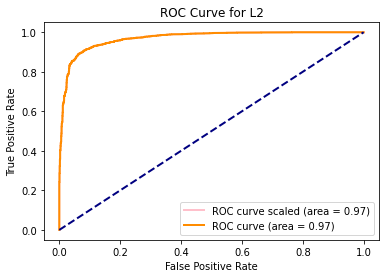

In [10]:
fpr, tpr, _ = roc_curve(Y_test, clf.decision_function(BOW_test))
roc_auc = auc(fpr, tpr)
fpr2, tpr2, _ = roc_curve(Y_test, clf.decision_function(BOW_test_scaled))
roc_auc2 = auc(fpr2, tpr2)
lw = 2
plt.plot(fpr2, tpr2, color='pink',lw=lw, label='ROC curve scaled (area = %0.2f)' % roc_auc2)
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for L2')
plt.legend(loc="lower right")
plt.show()

*Feature Importance*

https://towardsdatascience.com/a-look-into-feature-importance-in-logistic-regression-models-a4aa970f9b0f

1. Coefficients




In [ ]:
features = BOW_vectorizer.get_feature_names()

In [ ]:
coef = clf.coef_

In [ ]:
important = {}
for i in range(len(coef[0])):
  if coef[0][i]>2.5 or coef[0][i]<-2.5:
    important[features[i]] = abs(coef[0][i])

In [ ]:
important = {k: v for k, v in sorted(important.items(), key=lambda item: item[1])}

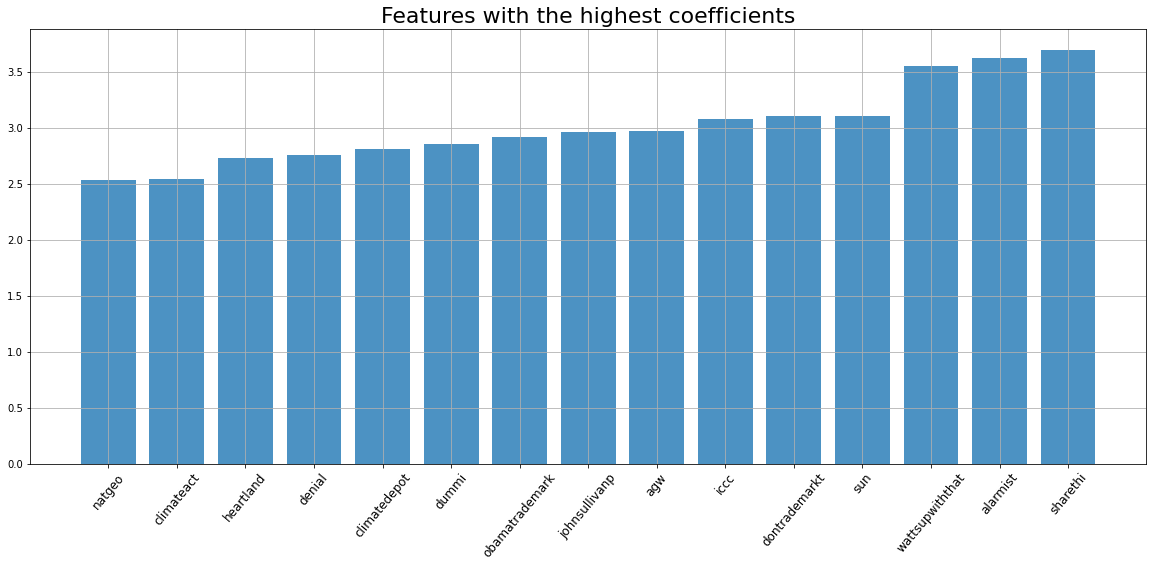

In [ ]:
import operator
plt.figure(figsize=(20,8))
plt.bar([x for x in range(len(important))], important.values(),align='center',alpha=0.8)
plt.xticks(ticks=range(len(important)),labels=important.keys(),rotation=50,fontsize=12)
plt.title('Features with the highest coefficients',fontsize=22)
plt.grid()
plt.show()

In [ ]:
useless = []
for i in range(len(coef[0])):
  if coef[0][i]==0:
    useless.append(features[i])
useless # there are o useless features, aka features with coefficient == 0 (we dont take it into consideration in our model)

[]

2. RFE

In [ ]:
from sklearn.feature_selection import RFE
predictors = BOW_train
selector = RFE(clf, n_features_to_select  =1)
selector = selector.fit(predictors, Y_train)

In [ ]:
order = selector.ranking_

In [ ]:
feature_ranks = {}
for i in range(len(order)):
  if order[i] <= 20 :
    feature_ranks[features[i]] = order[i]
feature_ranks = sorted(feature_ranks.items(), key=lambda item: item[1])

In [ ]:
print("Top 20 RFE")
print("----------")
for i in range(len(feature_ranks)):
  print(feature_ranks[i][1],feature_ranks[i][0] )

Note: 

iccc ---> International Conference on Climate Change

agw ---> Anthropogenic global warming

3. SelectFromModel

In [ ]:
from sklearn.feature_selection import SelectFromModel
from itertools import compress

smf = SelectFromModel(clf, threshold = np.inf, max_features = 20)
smf.fit(BOW_train, Y_train)
feature_idx = smf.get_support()
feature_name = list(compress(features, feature_idx))
feature_name

In [ ]:
(feature_idx == True).any()

> # **BoW (Bigrams)**

In [11]:
BBOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                 binary=True, # Creates 0/1 "One Hot" vector; 
                                              # np.unique(BOW_train.toarray())
                                 min_df = 10,
                                 ngram_range = (1,2))
BBOW_vectorizer.fit(X_train)
BBOW_train = BBOW_vectorizer.transform(X_train)
BBOW_test = BBOW_vectorizer.transform(X_test)
scaler = MaxAbsScaler().fit(BBOW_train)
BBOW_train_scaled = scaler.transform(BBOW_train)
BBOW_test_scaled = scaler.transform(BBOW_test)

#### Best Mean Accuracy Estimator so far 

In [12]:
clf = LogisticRegression(C = 1, max_iter = 1000, multi_class = "ovr", solver = "saga")

Scaled

In [13]:
clf.fit(BBOW_train_scaled, Y_train) 
pred = clf.predict(BBOW_test_scaled)
accuracy = accuracy_score(Y_test,pred)
precision = precision_score(Y_test,pred)
recall = recall_score(Y_test,pred)
f1 = f1_score(Y_test,pred)
f2 = fbeta_score(Y_test,pred,beta=2)
f5 = fbeta_score(Y_test,pred,beta=2)
auc_score = roc_auc_score(Y_test, clf.predict_proba(BBOW_test_scaled)[:, 1])

print('##########')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('f1_score: {}'.format(round(f1,4)))
print('f2_score: {}'.format(round(f2,4)))
print('f5_score: {}'.format(round(f5,4)))
print("Auc score : {}".format(round(auc_score,4)))
print('##########')
print()

##########
Accuracy: 0.9203
Precision: 0.9267
Recall: 0.9401
f1_score: 0.9334
f2_score: 0.9374
f5_score: 0.9374
Auc score : 0.9723
##########



Non Scaled

In [14]:
clf.fit(BBOW_train, Y_train) # scaled
pred = clf.predict(BBOW_test)
accuracy = accuracy_score(Y_test,pred)
precision = precision_score(Y_test,pred)
recall = recall_score(Y_test,pred)
f1 = f1_score(Y_test,pred)
f2 = fbeta_score(Y_test,pred,beta=2)
f5 = fbeta_score(Y_test,pred,beta=2)
auc_score = roc_auc_score(Y_test, clf.predict_proba(BBOW_test)[:, 1])


print('##########')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('f1_score: {}'.format(round(f1,4)))
print('f2_score: {}'.format(round(f2,4)))
print('f5_score: {}'.format(round(f5,4)))
print("Auc score : {}".format(round(auc_score,4)))
print('##########')
print()

##########
Accuracy: 0.9203
Precision: 0.9267
Recall: 0.9401
f1_score: 0.9334
f2_score: 0.9374
f5_score: 0.9374
Auc score : 0.9723
##########



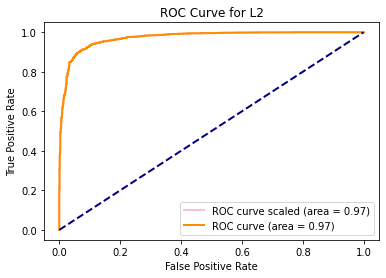

In [15]:
fpr, tpr, _ = roc_curve(Y_test, clf.decision_function(BBOW_test))
roc_auc = auc(fpr, tpr)
fpr2, tpr2, _ = roc_curve(Y_test, clf.decision_function(BBOW_test_scaled))
roc_auc2 = auc(fpr2, tpr2)

plt.plot(fpr2, tpr2, color='pink',lw=lw, label='ROC curve scaled (area = %0.2f)' % roc_auc2)
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for L2')
plt.legend(loc="lower right")
plt.show()

> # **FBoW**

In [16]:
FBOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                  binary=False, # Creates Word Frequency Vector; 
                                                # # np.unique(FBOW_train.toarray())
                                  min_df = 10)
FBOW_vectorizer.fit(X_train)
FBOW_train = FBOW_vectorizer.transform(X_train)
FBOW_test = FBOW_vectorizer.transform(X_test)
scaler = MaxAbsScaler().fit(FBOW_train)
FBOW_train_scaled = scaler.transform(FBOW_train)
FBOW_test_scaled = scaler.transform(FBOW_test)

#### Contrasting Classifiers for Scaled and Non Scaled (Scaled -> L2, Non Scaled -> Elasticnet)
L2

In [17]:
clf = LogisticRegression(C = 1, max_iter = 1000, multi_class = "ovr", solver = "liblinear")

Scaled - L2

In [18]:
clf.fit(FBOW_train_scaled, Y_train) # scaled
pred = clf.predict(FBOW_test_scaled)
accuracy = accuracy_score(Y_test,pred)
precision = precision_score(Y_test,pred)
recall = recall_score(Y_test,pred)
f1 = f1_score(Y_test,pred)
f2 = fbeta_score(Y_test,pred,beta=2)
f5 = fbeta_score(Y_test,pred,beta=2)
auc_score = roc_auc_score(Y_test, clf.predict_proba(FBOW_test_scaled)[:, 1])

print('##########')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('f1_score: {}'.format(round(f1,4)))
print('f2_score: {}'.format(round(f2,4)))
print('f5_score: {}'.format(round(f5,4)))
print("Auc score : {}".format(round(auc_score,4)))
print('##########')
print()

##########
Accuracy: 0.9117
Precision: 0.9201
Recall: 0.9322
f1_score: 0.9261
f2_score: 0.9297
f5_score: 0.9297
Auc score : 0.9702
##########



Non Scaled - L2

In [19]:
clf.fit(FBOW_train, Y_train) # scaled
pred = clf.predict(FBOW_test)
accuracy = accuracy_score(Y_test,pred)
precision = precision_score(Y_test,pred)
recall = recall_score(Y_test,pred)
f1 = f1_score(Y_test,pred)
f2 = fbeta_score(Y_test,pred,beta=2)
f5 = fbeta_score(Y_test,pred,beta=2)
auc_score = roc_auc_score(Y_test, clf.predict_proba(FBOW_test)[:, 1])


print('##########')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('f1_score: {}'.format(round(f1,4)))
print('f2_score: {}'.format(round(f2,4)))
print('f5_score: {}'.format(round(f5,4)))
print("Auc score : {}".format(round(auc_score,4)))
print('##########')
print()

##########
Accuracy: 0.91
Precision: 0.9187
Recall: 0.9308
f1_score: 0.9247
f2_score: 0.9283
f5_score: 0.9283
Auc score : 0.969
##########



Elasticnet - Scaled

In [20]:
clf = LogisticRegression(C = 1, max_iter = 1000, multi_class = "ovr", l1_ratio = 0.2, penalty = "elasticnet", solver = "saga")

In [21]:
clf.fit(FBOW_train_scaled, Y_train) # scaled
pred = clf.predict(FBOW_test_scaled)
accuracy = accuracy_score(Y_test,pred)
precision = precision_score(Y_test,pred)
recall = recall_score(Y_test,pred)
f1 = f1_score(Y_test,pred)
f2 = fbeta_score(Y_test,pred,beta=2)
f5 = fbeta_score(Y_test,pred,beta=2)
auc_score = roc_auc_score(Y_test, clf.predict_proba(FBOW_test_scaled)[:, 1])

print('##########')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('f1_score: {}'.format(round(f1,4)))
print('f2_score: {}'.format(round(f2,4)))
print('f5_score: {}'.format(round(f5,4)))
print("Auc score : {}".format(round(auc_score,4)))
print('##########')
print()

##########
Accuracy: 0.91
Precision: 0.918
Recall: 0.9317
f1_score: 0.9248
f2_score: 0.9289
f5_score: 0.9289
Auc score : 0.9705
##########



Elasticnet - Non Scaled

In [22]:
clf.fit(FBOW_train, Y_train) # scaled
pred = clf.predict(FBOW_test)
accuracy = accuracy_score(Y_test,pred)
precision = precision_score(Y_test,pred)
recall = recall_score(Y_test,pred)
f1 = f1_score(Y_test,pred)
f2 = fbeta_score(Y_test,pred,beta=2)
f5 = fbeta_score(Y_test,pred,beta=2)
auc_score = roc_auc_score(Y_test, clf.predict_proba(FBOW_test)[:, 1])


print('##########')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('f1_score: {}'.format(round(f1,4)))
print('f2_score: {}'.format(round(f2,4)))
print('f5_score: {}'.format(round(f5,4)))
print("Auc score : {}".format(round(auc_score,4)))
print('##########')
print()

##########
Accuracy: 0.9095
Precision: 0.9179
Recall: 0.9308
f1_score: 0.9243
f2_score: 0.9282
f5_score: 0.9282
Auc score : 0.9694
##########



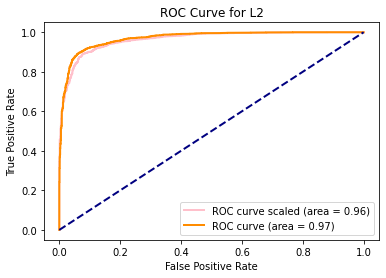

In [23]:
fpr, tpr, _ = roc_curve(Y_test, clf.decision_function(FBOW_test))
roc_auc = auc(fpr, tpr)
fpr2, tpr2, _ = roc_curve(Y_test, clf.decision_function(FBOW_test_scaled))
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, color='pink',lw=lw, label='ROC curve scaled (area = %0.2f)' % roc_auc2)
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for L2')
plt.legend(loc="lower right")
plt.show()

# TFIDF

In [24]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   min_df=10) # used for now for consistency
tfidf_vectorizer.fit(X_train)
TFIDF_train = tfidf_vectorizer.transform(X_train)
TFIDF_test = tfidf_vectorizer.transform(X_test)

In [25]:
scaler = MaxAbsScaler().fit(TFIDF_train)
TFIDF_train_scaled = scaler.transform(TFIDF_train)
TFIDF_test_scaled = scaler.transform(TFIDF_test)

In [26]:
clf = LogisticRegression(C = 1, l1_ratio = 0.2,  penalty = "elasticnet", max_iter = 1000, multi_class = "ovr", solver = "saga")

Scaled

In [27]:
clf.fit(TFIDF_train_scaled, Y_train) # scaled

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.2, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
pred = clf.predict(TFIDF_test_scaled)
accuracy = accuracy_score(Y_test,pred)
precision = precision_score(Y_test,pred)
recall = recall_score(Y_test,pred)
f1 = f1_score(Y_test,pred)
f2 = fbeta_score(Y_test,pred,beta=2)
f5 = fbeta_score(Y_test,pred,beta=2)
auc_score = roc_auc_score(Y_test, clf.predict_proba(TFIDF_test_scaled)[:, 1])

print('##########')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('f1_score: {}'.format(round(f1,4)))
print('f2_score: {}'.format(round(f2,4)))
print('f5_score: {}'.format(round(f5,4)))
print("Auc score : {}".format(round(auc_score,4)))
print('##########')
print()

##########
Accuracy: 0.9153
Precision: 0.9257
Recall: 0.9322
f1_score: 0.9289
f2_score: 0.9309
f5_score: 0.9309
Auc score : 0.9702
##########



Non Scaled

In [29]:
clf.fit(TFIDF_train, Y_train) # scaled

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.2, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
pred = clf.predict(TFIDF_test)
accuracy = accuracy_score(Y_test,pred)
precision = precision_score(Y_test,pred)
recall = recall_score(Y_test,pred)
f1 = f1_score(Y_test,pred)
f2 = fbeta_score(Y_test,pred,beta=2)
f5 = fbeta_score(Y_test,pred,beta=2)
auc_score = roc_auc_score(Y_test, clf.predict_proba(TFIDF_test)[:, 1])


print('##########')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('f1_score: {}'.format(round(f1,4)))
print('f2_score: {}'.format(round(f2,4)))
print('f5_score: {}'.format(round(f5,4)))
print("Auc score : {}".format(round(auc_score,4)))
print('##########')
print()

##########
Accuracy: 0.9134
Precision: 0.9243
Recall: 0.9303
f1_score: 0.9273
f2_score: 0.9291
f5_score: 0.9291
Auc score : 0.9686
##########



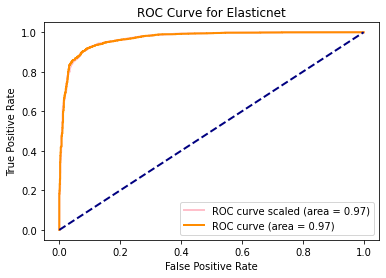

In [31]:
fpr, tpr, _ = roc_curve(Y_test, clf.decision_function(TFIDF_test))
roc_auc = auc(fpr, tpr)
fpr2, tpr2, _ = roc_curve(Y_test, clf.decision_function(TFIDF_test_scaled))
roc_auc2 = auc(fpr2, tpr2)

plt.plot(fpr2, tpr2, color='pink',lw=lw, label='ROC curve scaled (area = %0.2f)' % roc_auc2)
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Elasticnet')
plt.legend(loc="lower right")
plt.show()